In [1]:
#this is all copied from https://pytorch.org/tutorials/advanced/neural_style_tutorial.html
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

from torchvision.utils import save_image
import torch
import torchvision

import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cnn = models.vgg19(pretrained=True).features.to(device).eval()

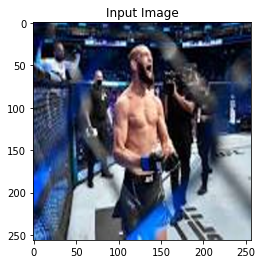

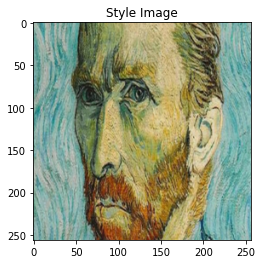

In [2]:

# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 256  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image):
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

styleimage=Image.open("images/conorpainting.jpeg")  #this one is good 
#styleimage=Image.open("images/fightersstyle.jpeg")
#styleimage=Image.open("images/fightersstyle2.jpeg")
styleimage2=Image.open("images/picasso.jpeg")  #this one is good
styleimage3=Image.open("images/paintedoblivion.webp")
styleimage4=Image.open("images/starrynight.jpeg")
styleimage5=Image.open("images/bear.jpeg")
styleimage6=Image.open("images/god.jpeg")
styleimage7=Image.open("images/vangogh.jpeg")  #this one is good


styleimage=styleimage.resize((256,256))
styleimage2=styleimage2.resize((256,256))
styleimage3=styleimage3.resize((256,256))
styleimage4=styleimage4.resize((256,256))
styleimage5=styleimage5.resize((256,256))
styleimage6=styleimage6.resize((256,256))
styleimage7=styleimage7.resize((256,256))

#fighterimage=Image.open("images/1KhabibNurmagomedov.jpg")
#fighterimage=Image.open("images/1TonyFerguson.jpg")
#fighterimage=Image.open("images/1DonaldCerrone.jpg")
#fighterimage=Image.open("images/1IanGarry.jpg")
fighterimage=Image.open("images/2KhamzatChimaev.jpg")

fighterimage=fighterimage.resize((256,256))

style = [image_loader(styleimage),image_loader(styleimage2),image_loader(styleimage3), image_loader(styleimage4)
        , image_loader(styleimage5), image_loader(styleimage6), image_loader(styleimage7)]

content_img = image_loader(fighterimage)
assert all(style[i].size() == content_img.size() for i in range(len(style))), \
    "we need to import style and content images of the same size"

unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated
    
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input
    
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input
    
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std
    
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')
imshow(style[-1], title='Style Image')

def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                if style_score.item()>200:
                    print('style score bigger than 200')
                    return False #quit running if the style score is too big (we'll get a bad image)

            return style_score + content_score
        
        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

def run_style_transfer_adaptive(cnn, normalization_mean, normalization_std,
                       content_img, styleindex, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    style_img=style[styleindex]
    firstLoss={0:0}
    """Run the style transfer."""
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    model.requires_grad_(False)
    optimizer = get_input_optimizer(input_img)
    run = [0]
    while run[0] <= num_steps and firstLoss[0]==0:
        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)
            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0
            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss
            style_score *= style_weight
            content_score *= content_weight
            loss = style_score + content_score
            loss.backward()
            run[0] += 1
            if run[0] % 50 == 0:
                if style_score.item()>170:
                    firstLoss[0]=style_score.item()
            return style_score + content_score
        optimizer.step(closure)
    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)
    if firstLoss[0]==0:
        return input_img
    else:
        return 'empty'

In [ ]:
#testing stylization
fighterimage=Image.open("images/1NateDiaz.jpg")
fighterimage=fighterimage.resize((256,256))
content_img = image_loader(fighterimage)
styleindex=random.randint(1,len(style))-1
output = 'empty'
while output =='empty':
    input_img = content_img.clone()
    styleindex=(styleindex+1)%len(style)
    print('trying style number '+str((styleindex+1)%len(style)))
    output = run_style_transfer_adaptive(cnn, cnn_normalization_mean, cnn_normalization_std,
                       content_img, styleindex, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1)

In [3]:
ufcfighterscrap =pd.read_csv('fighter_stats.csv',sep=',',low_memory=False)
names = list(ufcfighterscrap['name'])

In [ ]:
90*4/60

In [ ]:
names[8:200]

In [ ]:
#this builds a folder images2 with 4 stylized images for each ufc fighter in history
#0-7 done
#can run about 90 overnight
for name in names[8:100]:
    for j in range(1,5):
        try:
            name = name.replace(" ","")
            fighterimage=Image.open("images/"+str(j)+name+".jpg")
            fighterimage=fighterimage.resize((256,256))
            content_img = image_loader(fighterimage)
            styleindex=random.randint(1,len(style))-1
            output = 'empty'
            k=0
            while output =='empty' and k<=5:
                k+=1
                input_img = content_img.clone()
                styleindex=(styleindex+1)%len(style)
                print('trying style number '+str((styleindex+1)%len(style)))
                output = run_style_transfer_adaptive(cnn, cnn_normalization_mean, cnn_normalization_std,
                                   content_img, styleindex, input_img, num_steps=300,
                                   style_weight=1000000, content_weight=1)
            img1 = output
            save_image(img1, "images2/"+str(j)+name+".jpg")
        except:
            continue

In [ ]:
#this builds a folder images2 with 4 stylized images for each ufc fighter in history
#0-7 done
#can run about 90 overnight
for name in names[100:200]:
    for j in range(1,5):
        try:
            name = name.replace(" ","")
            fighterimage=Image.open("images/"+str(j)+name+".jpg")
            fighterimage=fighterimage.resize((256,256))
            content_img = image_loader(fighterimage)
            styleindex=random.randint(1,len(style))-1
            output = 'empty'
            k=0
            while output =='empty' and k<=5:
                k+=1
                input_img = content_img.clone()
                styleindex=(styleindex+1)%len(style)
                print('trying style number '+str((styleindex+1)%len(style)))
                output = run_style_transfer_adaptive(cnn, cnn_normalization_mean, cnn_normalization_std,
                                   content_img, styleindex, input_img, num_steps=300,
                                   style_weight=1000000, content_weight=1)
            img1 = output
            save_image(img1, "images2/"+str(j)+name+".jpg")
        except:
            continue

In [4]:
#this builds a folder images2 with 4 stylized images for each ufc fighter in history
#0-200 done... testing next 30 to see if there are any running poorly
#can run about 90 overnight
for name in names[200:230]:
    for j in range(1,5):
        try:
            name = name.replace(" ","")
            fighterimage=Image.open("images/"+str(j)+name+".jpg")
            fighterimage=fighterimage.resize((256,256))
            content_img = image_loader(fighterimage)
            styleindex=random.randint(1,len(style))-1
            output = 'empty'
            k=0
            while output =='empty':
                if k>len(style):
                    print('couldnt find a good style for '+str(j)+name)
                    break
                k+=1
                input_img = content_img.clone()
                styleindex=(styleindex+1)%len(style)
                print('trying style number '+str(styleindex)+' for '+name)
                output = run_style_transfer_adaptive(cnn, cnn_normalization_mean, cnn_normalization_std,
                                   content_img, styleindex, input_img, num_steps=300,
                                   style_weight=1000000, content_weight=1)
            img1 = output
            save_image(img1, "images2/"+str(j)+name+".jpg")
            print('saving: '+"images2/"+str(j)+name+".jpg"+' in style '+str(styleindex))
        except:
            continue

trying style number 2 for ChrisWeidman


/var/folders/zr/jttn57m976g1m1_y2p2t8zwm0000gn/T/ipykernel_21743/241124489.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
/var/folders/zr/jttn57m976g1m1_y2p2t8zwm0000gn/T/ipykernel_21743/241124489.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


saving: images2/1ChrisWeidman.jpg in style 2
trying style number 0 for ChrisWeidman
saving: images2/2ChrisWeidman.jpg in style 0
trying style number 4 for ChrisWeidman
trying style number 5 for ChrisWeidman
saving: images2/3ChrisWeidman.jpg in style 5
trying style number 5 for ChrisWeidman
saving: images2/4ChrisWeidman.jpg in style 5
trying style number 3 for OmariAkhmedov
trying style number 4 for OmariAkhmedov
saving: images2/1OmariAkhmedov.jpg in style 4
trying style number 1 for OmariAkhmedov
trying style number 2 for OmariAkhmedov
trying style number 3 for OmariAkhmedov
trying style number 4 for OmariAkhmedov
trying style number 5 for OmariAkhmedov
saving: images2/2OmariAkhmedov.jpg in style 5
trying style number 6 for OmariAkhmedov
saving: images2/3OmariAkhmedov.jpg in style 6
trying style number 6 for OmariAkhmedov
saving: images2/4OmariAkhmedov.jpg in style 6
trying style number 5 for DarrenStewart
saving: images2/1DarrenStewart.jpg in style 5
trying style number 5 for DarrenSt

saving: images2/3YoussefZalal.jpg in style 6
trying style number 6 for YoussefZalal
saving: images2/4YoussefZalal.jpg in style 6
trying style number 6 for PeterBarrett
saving: images2/1PeterBarrett.jpg in style 6
trying style number 3 for PeterBarrett
trying style number 4 for PeterBarrett
trying style number 5 for PeterBarrett
saving: images2/2PeterBarrett.jpg in style 5
trying style number 0 for PeterBarrett
trying style number 1 for PeterBarrett
trying style number 2 for PeterBarrett
trying style number 3 for PeterBarrett
saving: images2/3PeterBarrett.jpg in style 3
trying style number 4 for PeterBarrett
trying style number 5 for PeterBarrett
saving: images2/4PeterBarrett.jpg in style 5
trying style number 2 for IrwinRivera
saving: images2/1IrwinRivera.jpg in style 2
trying style number 1 for IrwinRivera
trying style number 2 for IrwinRivera
trying style number 3 for IrwinRivera
trying style number 4 for IrwinRivera
trying style number 5 for IrwinRivera
saving: images2/2IrwinRivera.

In [ ]:
#this builds a folder images2 with 4 stylized images for each ufc fighter in history
#0-200 done... testing next 30 to see if there are any running poorly
#can run about 90 overnight
for name in names[230:250]:
    for j in range(1,5):
        try:
            name = name.replace(" ","")
            fighterimage=Image.open("images/"+str(j)+name+".jpg")
            fighterimage=fighterimage.resize((256,256))
            content_img = image_loader(fighterimage)
            styleindex=random.randint(1,len(style))-1
            output = 'empty'
            k=0
            while output =='empty':
                if k>len(style):
                    print(str(j)+' couldnt find a good style for '+str(j)+name)
                    break
                k+=1
                input_img = content_img.clone()
                styleindex=(styleindex+1)%len(style)
                output = run_style_transfer_adaptive(cnn, cnn_normalization_mean, cnn_normalization_std,
                                   content_img, styleindex, input_img, num_steps=300,
                                   style_weight=1000000, content_weight=1)
            img1 = output
            save_image(img1, "images2/"+str(j)+name+".jpg")
            print(str(j)+' saving: '+"images2/"+str(j)+name+".jpg"+' in style '+str(styleindex))
        except:
            continue

In [ ]:
plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

In [ ]:
img1 = output
# img1 = img1.numpy() # TypeError: tensor or list of tensors expected, got <class 'numpy.ndarray'>
save_image(img1, 'img1.png')

In [ ]:
fighterimage=Image.open("images/4ConorMcGregor.jpg");fighterimage

In [ ]:
#to test the most recently added style image
fighterimage=fighterimage.resize((256,256))
content_img = image_loader(fighterimage)
input_img = content_img.clone()
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style[-1], input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()